In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import bernoulli, binom, beta
from math import comb
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Problem 1

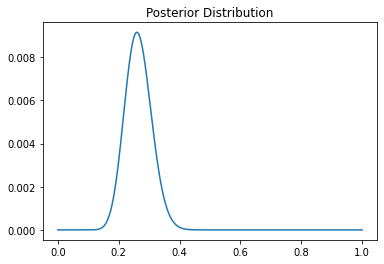

0.2602602602602603


In [2]:
def bernoulli_sampling(p, n):
    """
    Simulate n tosses of a coin which gives heads with probability 
    p. Then use that sample to calculate the posterior distribution on 
    p given a uniform prior.

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate

    Returns:
        (float): The MAP estimate of p
    """
    
    successes = np.random.binomial(n, p, 1)[0]      #count the number of heads
    
    p_options = np.linspace(0, 1, 1000)             #make an array of options for p
    
    pmf = p_options ** successes * ((1 - p_options) ** (n - successes))  #use pmf for bernoulli
    
    posterior = pmf / np.sum(pmf)   #calculate posterior pdf
    
    MAP = p_options[np.argmax(posterior)]      #find MAP by using argmax of posterior
    
    plt.plot(p_options, posterior)
    plt.title("Posterior Distribution")       #plot
    plt.show()
    
    return MAP

print(bernoulli_sampling(.2, 100))

# Problem 2

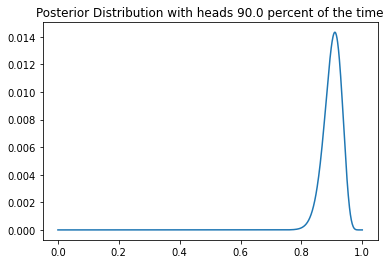

0.9099099099099099


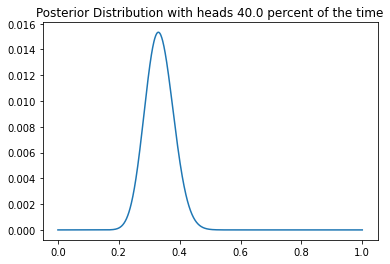

0.3303303303303303
The posterior distribution of the higher percentage of heads is more tightly distributed, so we have more confidence with regard to this estimation


In [3]:
def non_uniform_prior(p, n, prior):
    """
    Generate a sample of size n that has a Bernoulli
    distribution with a probability parameter p.
    Use Bayes' theorem to compute the posterior distribution
    for the given prior and the generated sample:
    
        P(t|x) = P(x|t) P(t) / P(x)
    
    Plot both prior and posterior distributions between [0, 1]

    Parameters:
        p (float): probability of a successful bernoulli trial
        n (int): number of bernoulli trials to simulate
        prior (scipy dist): the prior distribution on p

    Returns:
        (float): MAP estimate
    """
    
    successes = np.random.binomial(n, p, 1)[0]      #count number of successes
    
    p_options = np.linspace(0, 1, 1000)         
    
    bern_pmf = p_options ** successes * ((1 - p_options) ** (n - successes))    #calculate pmf of Bernoulli
    
    prior_p = prior.pdf(p)     #calculate the prior pdf of p
    
    prior_theta = prior.pdf(p_options)        #calculate the prior pdf of all possible options of p
    
    posterior = bern_pmf * prior_p / np.sum(bern_pmf * prior_theta)     #calculate posterior distribution
    
    MAP = p_options[np.argmax(posterior)]   #find MAP by finding argmax of posterior
    
    plt.plot(p_options, posterior)             #plot the posterior distribution
    plt.title("Posterior Distribution with heads " + str(p*100) + " percent of the time")
    plt.show()
    
    return MAP

print(non_uniform_prior(.9, 100, scipy.stats.beta(5,1.5)))
print(non_uniform_prior(.4, 100, scipy.stats.beta(5,1.5)))

print("The posterior distribution of the higher percentage of heads is more tightly distributed, so we have more confidence with regard to this estimation")
    

# Problem 3

In [4]:
def weather_forecast(transition_matrix, days=10):
    """
    Given the above transition matrix and assuming the 0th day is sunny,
    sample from the markov chain to give a possible forecast of the 10 following
    days. 
    """
    
    states = {0: "sun", 1: "rain", 2: "wind"}    #make a dictionary of the states and their associated rows
    
    forecast = []          #make a list of conditions
    
    current = 0
    
    for i in range(days):
        current = np.random.choice(3, p=transition_matrix[current, :])    #transition to the next state based on the current probabilities
        forecast.append(states[current])     #add the current state to our forecast list
        
    return forecast

In [5]:
transition_matrix = np.array(
  [
    [0.6,0.1,0.3],
    [0.2,0.6,0.2],
    [0.3,0.4,0.3]
  ]
)

print(weather_forecast(transition_matrix))

['sun', 'wind', 'wind', 'rain', 'rain', 'rain', 'sun', 'sun', 'sun', 'sun']


# Problem 4

In [6]:
def posterior_sampling(data, n=1000):
    """
    Given data that flips a coin 100 times, assume the data are distributed 
    as Bernoulli(p) for some unknown value of p, where p has a prior of 
    Beta(1,1). Set up a PyMC3 model for this situation and sample from the 
    poterior n times. Print a trace plot. Return the mean for the posterior.
    
    Parameters:
        data (array): The coin flips
        n (int): number of samples to take from the posterior
        
    Returns:
        Mean (float): The average of the coin flips (estimated p)
    """
    
    model = pm.Model()
    with model:
        pvalue = pm.Beta('pvalue', alpha=1, beta=1)    #use a prior for p of Beta(1,1)
        y = pm.Bernoulli('y', p=pvalue, observed=data)     #the data is Bernoulli distributed
        trace = pm.sample(n) #n is the desired number of samples
            
        az.plot_trace(trace)     #create plot of the pvalue
        pvalue = trace['pvalue']
        mean = pvalue.mean()       #calculate the average of the coin flips
            
    return mean


<ipython-input-6-8fb123a094be>:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n) #n is the desired number of samples
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pvalue]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


0.18732841629989602


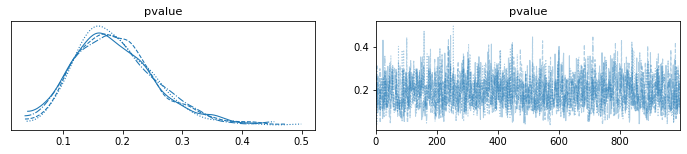

In [7]:
data = bernoulli.rvs(0.2, size=30)
print(posterior_sampling(data))

# Problem 5

In [8]:
def height_model(observed_heights,m=180,s=10,alpha=2,beta=10,n=1000):

    """
    Given a dataset of the measured heights of 100 men, assume the data are
    distributed as Normal(mu,1/tau) where mu has a prior of Normal(m,s), and tau has
    a prior of Gamma(alpha,beta). Set up a PyMC3 model for this situation and sample 
    from the poterior n times. Print a trace plot for mu and tau. Return the mean 
    for the posterior of mu.
    
    Parameters:
        observed_heights (array): The measured heights of 100 men
        m (int): the mean in the prior distribution of mu
        s (int): the standard deviation in the prior distribution of mu
        alpha (int): the first component in the prior distibution of tau
        beta (int): the second component in the prior distribution of tau
        n (int): number of samples from the posterior
        
    Returns:
        mu_mean (float): the estimated value of mu
    """
    
    model = pm.Model()
    with model:
        mu = pm.Normal('mu', mu=m, sigma=s)    #mu has a normally distributed prior
        tau = pm.Gamma('tau', alpha=alpha, beta=beta)  #tau has a Gamma prior
        y = pm.Normal('y', mu=mu, sigma=1/tau, observed=observed_heights)   #the data are normall distributed
        trace = pm.sample(n)  #n is the desired number of samples
        
        az.plot_trace(trace)     #plot the instances of tau and mu at each value
        mu = trace['mu']
        tau = trace['tau']
        mean_mu = mu.mean()      #calcuate the estimated value of mu
        
    return mean_mu

<ipython-input-8-b243111bb7af>:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(n)  #n is the desired number of samples
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8967397273381608, but should be close to 0.8. Try to increase the number of tuning steps.


178.65145438029953


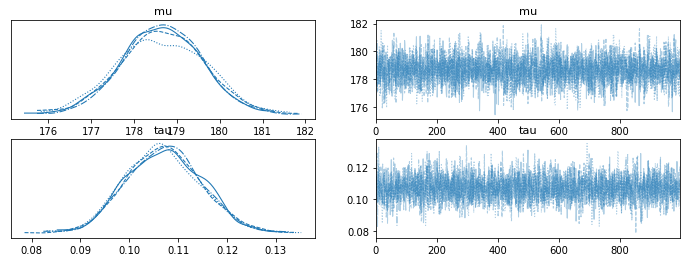

In [9]:
heights = np.random.normal(180,10,100)
print(height_model(heights))